# Import libraries and data


In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.1 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np

In [4]:
from google.colab import drive

drive.mount("/content/gdrive/")

Mounted at /content/gdrive/


In [13]:
df = pd.read_csv('/content/gdrive/My Drive/IIT 🎓/FYP/Dataset/processed_data.csv',
                 index_col = "Date", 
                 parse_dates = True)

df.head(1)

,index,Price,Anuradhapura_Producer_Price,Kurunegala_Producer_Price,Polonnaruwa_Producer_Price,Producer_Price,Production,Production_Total,Exchange_Rate,Fuel_Price
Date,,,,,,,,,,
1996-01-01,0,18.07,7.75,7.9,8.18,8.18,1333.6,2065.1,53.685,12.4


In [34]:
#select variables
dataset = df.loc[:,  ['Price', 'Producer_Price', 'Exchange_Rate', 'Fuel_Price']]
dataset.head(1)                       

,Price,Producer_Price,Exchange_Rate,Fuel_Price
Date,,,,
1996-01-01,18.07,8.18,53.685,12.4


#Data Transformation

In [35]:
#renaming variable
dataset = dataset.rename(columns = {'Price' : 'y'})
dataset.head(1)

,y,Producer_Price,Exchange_Rate,Fuel_Price
Date,,,,
1996-01-01,18.07,8.18,53.685,12.4


In [36]:
#index
dataset = dataset.asfreq("MS")
dataset.index

DatetimeIndex(['1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', name='Date', length=324, freq='MS')

#Visualization

<Axes: xlabel='Date'>

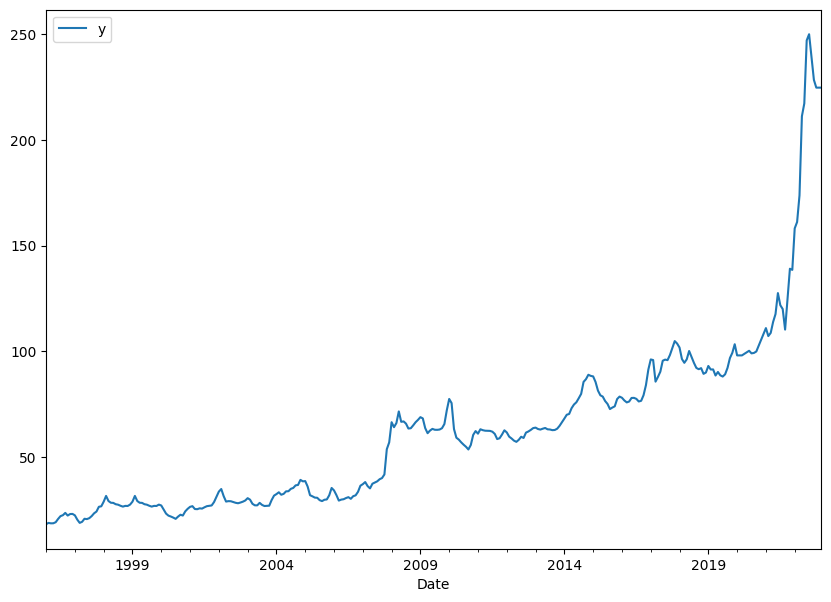

In [37]:
#viz
dataset["y"].plot(figsize = (10, 7), legend = True)

#Stationarity

In [38]:
#Stationarity
from statsmodels.tsa.stattools import adfuller
stationarity = adfuller(dataset['y'])
print('Augmented Dickey Fuller p-value: %F' % stationarity[1])

Augmented Dickey Fuller p-value: 0.997598


#Training and Test Set

In [39]:
#Training and test set
horizon = 12
dataset = dataset[(dataset.index < pd.to_datetime("2020-01-01"))]
training_set = dataset.iloc[:-horizon, :]
test_set = dataset.iloc[-horizon:, :]
test_set.tail(1)

,y,Producer_Price,Exchange_Rate,Fuel_Price
Date,,,,
2019-12-01,103.29,54.53,181.3,104.0


#Forecasting Model

In [40]:
#exogenous variables
train_exog = training_set.iloc[:,1:]
test_exog = test_set.iloc[:,1:]
test_exog.head()

,Producer_Price,Exchange_Rate,Fuel_Price
Date,,,
2019-01-01,35.383333,178.15,99.0
2019-02-01,30.940000,179.90,103.0
2019-03-01,35.620000,175.35,104.0
2019-04-01,40.130000,176.00,104.0
2019-05-01,43.920000,176.20,104.0


In [41]:
#Libraries
from pmdarima import auto_arima

In [42]:
#forecasting model
model = auto_arima(y = training_set['y'],
                   X = train_exog,
                   m = 12,
                   seasonal = True,
                   stepwise = False)

In [43]:
#summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  276
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 12)   Log Likelihood                -566.902
Date:                            Tue, 04 Apr 2023   AIC                           1151.804
Time:                                    14:33:15   BIC                           1184.388
Sample:                                01-01-1996   HQIC                          1164.880
                                     - 12-01-2018                                         
Covariance Type:                              opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.2304      0.240      0.961      0.336      -0.239       0.700
Producer_Price     0.4138      0.040     10.308      0.000       0.335       0.492
Exchange_Rate      0.0491      0.128      0.383      0.701      -0.202       0.300
Fuel_Price        -0.0278      0.018     -1.556      0.120      -0.063       0.007
ar.L1              1.1931      0.052     23.135      0.000       1.092       1.294
ar.L2             -0.2021      0.053     -3.815      0.000      -0.306      -0.098
ar.S.L12           0.1693      0.056      3.039      0.002       0.060       0.278
ar.S.L24           0.1444      0.060      2.400      0.016       0.027       0.262
sigma2             3.4862      0.202     17.222      0.000       3.089       3.883
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               549.19
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               3.87   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
#predictions
predictions_sarimax = pd.Series(model.predict(n_periods= horizon,
                              X = test_exog)).rename("SARIMAX")
predictions_sarimax.index = test_set.index                              
predictions_sarimax

Date
2019-01-01    88.891873
2019-02-01    87.149555
2019-03-01    86.398753
2019-04-01    88.592664
2019-05-01    90.633252
2019-06-01    89.567260
2019-07-01    89.727923
2019-08-01    90.853306
2019-09-01    92.349971
2019-10-01    92.765789
2019-11-01    92.430735
2019-12-01    93.691410
Freq: MS, Name: SARIMAX, dtype: float64

<Axes: xlabel='Date'>

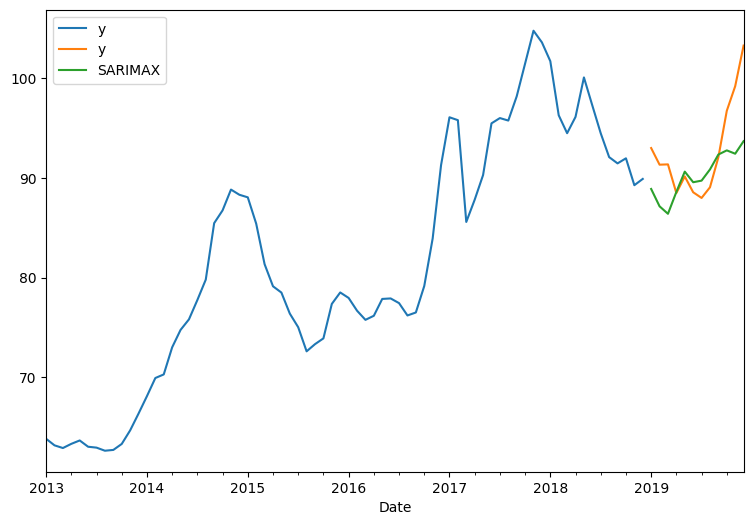

In [45]:
#visualization
training_set['y']['2013-01-01':].plot(figsize = (9,6), legend = True)
test_set['y'].plot(legend = True)
predictions_sarimax.plot(legend = True)

#Model assessment

In [46]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_sarimax),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_sarimax)), 0))

3.0
4.0


In [47]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_sarimax)

3.395166374771377

#export forecasts

In [ ]:
%cd /content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/0. Ensemble

/content/drive/MyDrive/Forecasting Models and Time Series for Business in Python/0. Ensemble


In [32]:
predictions_sarimax.to_csv('predictions_sarimax.csv', index = True)